# Quanvolutional Neural Networks

Convolutional Neural Networks (CNNs) are a type of deep learning model specifically designed for image processing. By applying filters to extract features from image data, CNNs can effectively learn to recognize patterns and make predictions.

Instead of looking at the whole picture at once, a CNN looks at small pieces of it. It's like examining a puzzle one piece at a time. Each piece is checked for specific things, like edges, colors, or shapes.

The CNN then combines all the information from these small pieces to understand the whole picture. It's like putting the puzzle together to see the big picture.

This process is called convolution. It helps the computer learn to recognize patterns in images, just like we do.

**Quantum Convolution**

Quantum convolution is a technique that applies the concept of convolutional neural networks (CNNs) to the quantum computing realm. Just like traditional CNNs process images by examining small sections, quantum convolution operates on small parts of an image using quantum circuits.

Here's how it works:
* Image Encoding: A small portion of the image is converted into a quantum state.
* Quantum Processing:  This quantum state undergoes a series of quantum operations, represented by a quantum circuit.
* Measurement:  The quantum system is measured, producing classical values.
* Feature Extraction:  These values become features for the next processing stage.

This process is repeated for different image sections, creating a new image-like structure. Unlike classical CNNs, quantum circuits can potentially generate highly complex patterns, offering advantages in image processing tasks.

Essentially, quantum convolution leverages the power of quantum computing to extract features from images in novel ways.


In [ ]:
!pip install pennylane

Setting up the environment and importing the necessary and related libraries or modules.

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Here we set up the main hyper paramenter of the model like number of layers, number of optimization epochs, size of the dataset, etc. We have also seeded randomly fo numpy and tensorflow, etc.

In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Here we mainly import the MNIST dataset, the very dataset we will be working on, from Keras. To speedup the evaluation of this demo we will be using only a small number of training and test images (However the full dataset must be used for better results).

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 [==============================] - 0s 0us/step


Here the Quantum circuit is being made which will later function as a convolutional kernel. We implement this via the Quanvolutional Neural Network, a quantum machine learning model originally introduced in Henderson et al. (2019).

First initialize a PennyLane default.qubit device, simulating a system of 4 qubits. The associated qnode represents the quantum circuit consisting of:

* An embedding layer of local Ry rotations (with angles
  scaled by a factor of π);

* A random circuit of n_layers;

* A final measurement in the computational basis, estimating
  4 expectation values.

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The next function defines the convolution scheme:

* The image is divided into squares of 2×2
  pixels;

* Each square is processed by the quantum circuit;

* The 4 expectation values are mapped into 4
  different channels of a single output pixel.



In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

To optimize our process, we will apply the quantum convolution layer as a preprocessing step to all images in our dataset. This means we'll transform each image once and save the result.

By doing this, we avoid repeating the computationally expensive quantum convolution process multiple times. Instead, we can focus on training a traditional machine learning model on the preprocessed images.

These preprocessed images will be stored for future use. If we need to use them again, we can simply load them without running the quantum convolution process again.

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


FileNotFoundError: [Errno 2] No such file or directory: '../_static/demonstration_assets/quanvolution/q_train_images.npy'

This block of code is helping us visualize  the effect of the quantum convolution layer on a batch of samples.

Below each input image, the 4 output channels generated by the quantum convolution are visualized in gray scale.

There is a noticeable downgrade in the resolution and some local distortion due to the local kernel.

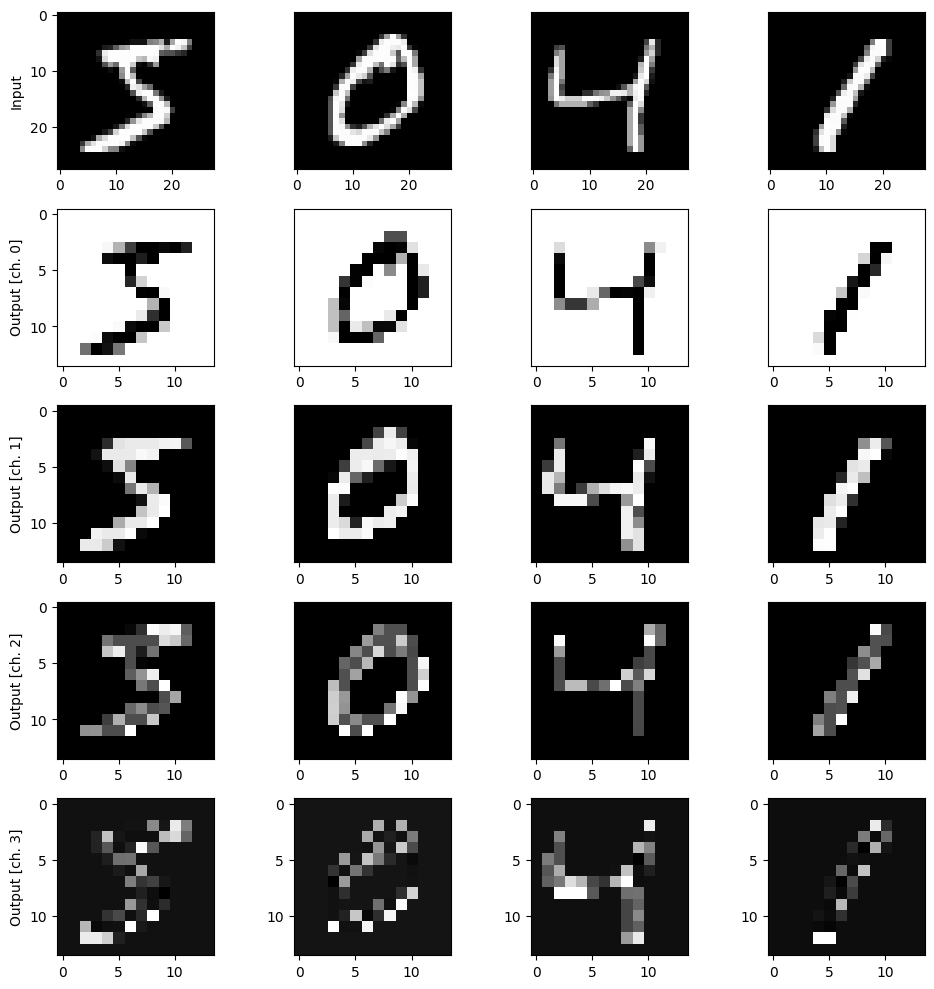

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

 We used a special computer thing called a quantum convolution. This made the images look different.

Then, we tried guessing what number the image is. This puzzle thing has 10 pieces, one for each number.

We taught the model to guess the right number by showing it lots of images and telling it the correct answer. Eventually, we used a special way to teach it called "stochastic-gradient-descent".

In [ ]:
def MyModel():
    #Initializes and returns a custom Keras model which is ready to be trained.
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

**Training**

Here we first initialize an instance of the model, then furthur we train and validate with the help of the dataset that has already been preprocessed by a Quantum Convolution.

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.7222 - accuracy: 0.2200 - val_loss: 2.1802 - val_accuracy: 0.2333 - 1s/epoch - 94ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0495 - accuracy: 0.2400 - val_loss: 1.9988 - val_accuracy: 0.3667 - 64ms/epoch - 5ms/step
Epoch 3/30
13/13 - 0s - loss: 1.6500 - accuracy: 0.5800 - val_loss: 1.9318 - val_accuracy: 0.4000 - 56ms/epoch - 4ms/step
Epoch 4/30
13/13 - 0s - loss: 1.3379 - accuracy: 0.7000 - val_loss: 1.7409 - val_accuracy: 0.4333 - 67ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.1309 - accuracy: 0.7400 - val_loss: 1.6426 - val_accuracy: 0.5000 - 76ms/epoch - 6ms/step
Epoch 6/30
13/13 - 0s - loss: 0.9603 - accuracy: 0.8400 - val_loss: 1.5735 - val_accuracy: 0.5000 - 62ms/epoch - 5ms/step
Epoch 7/30
13/13 - 0s - loss: 0.7747 - accuracy: 0.9000 - val_loss: 1.5190 - val_accuracy: 0.5667 - 68ms/epoch - 5ms/step
Epoch 8/30
13/13 - 0s - loss: 0.6446 - accuracy: 0.9600 - val_loss: 1.4280 - val_accuracy: 0.6667 - 70ms/epoch - 5ms/step
Epoch 9/30
13/13 - 0s - l

Now, we're going to try two things:

* Use the quantum image changer: We'll change the images
  with our special quantum method and then teach a computer to recognize numbers in these changed images.
* Don't use the quantum image changer: We'll use the original images without changing them and teach a different computer to recognize numbers in these regular images.


By comparing how well both computers do, we can figure out if our special quantum image changer actually makes a difference.

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.4490 - accuracy: 0.2000 - val_loss: 2.1367 - val_accuracy: 0.1667 - 637ms/epoch - 49ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0435 - accuracy: 0.2800 - val_loss: 1.9872 - val_accuracy: 0.3333 - 72ms/epoch - 6ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7249 - accuracy: 0.5400 - val_loss: 1.8650 - val_accuracy: 0.4333 - 58ms/epoch - 4ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4798 - accuracy: 0.8400 - val_loss: 1.7474 - val_accuracy: 0.5333 - 68ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2695 - accuracy: 0.8800 - val_loss: 1.6396 - val_accuracy: 0.6000 - 60ms/epoch - 5ms/step
Epoch 6/30
13/13 - 0s - loss: 1.1030 - accuracy: 0.9400 - val_loss: 1.5496 - val_accuracy: 0.6333 - 61ms/epoch - 5ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9599 - accuracy: 0.9400 - val_loss: 1.4857 - val_accuracy: 0.6333 - 74ms/epoch - 6ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8391 - accuracy: 0.9600 - val_loss: 1.4207 - val_accuracy: 0.6333 - 81ms/epoch - 6ms/step
Epoch 9/30
13/13 - 0s 

**Results**

Finally we plot the test accuracy and the test loss with respect to the number of training epochs.

<ipython-input-15-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


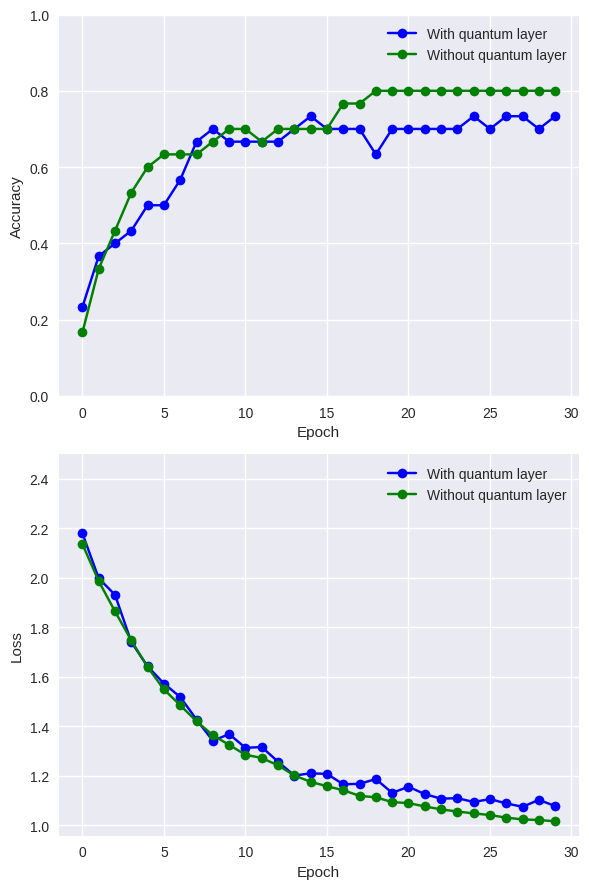

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()